In [ ]:
import numpy as np
import matplotlib.pyplot as plt

0.8364295364138072 -0.005809421301242236


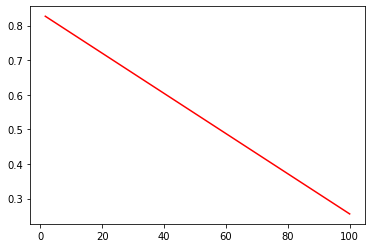

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
y = np.array([0.91, 0.5, 0.3])
x = np.array([10**0.2, 36, 100])
res = stats.linregress(x, y)

print(res.intercept, res.slope)

plt.plot(x, res.intercept + res.slope * x, 'r', label='fitted line')


def inhibition_ttx(self):
    intercept, slope = 0.8364295364138072, -0.005809421301242236
    perc = intercept + slope * self.concentration_ttx
    if concentration <= 1:
        return 1
    if perc < 0:
        return 0
    else:
        return perc

[1.]
[0.00026005]
/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


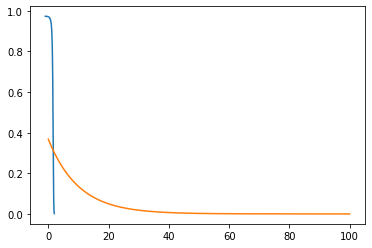

In [ ]:
from scipy.optimize import curve_fit

def invfsigmoid(x, a):
    return (1.0 / (1.0 + np.exp(a*(x-36))))

y = np.array([0.91, 0.5, 0.3])
x = np.array([10**0.2, 36, 100])
x2 = np.linspace(0,100,1000)

popt, pcov = curve_fit(invfsigmoid, np.log10(x), y)

print(popt)

plt.plot(np.log10(x2), invfsigmoid(x2,0.1))


def exponential(x,a):
    return 1/np.exp(1) * np.exp(-a*x)

popt, pcov = curve_fit(exponential, x, y)
print(popt)

plt.plot(x2, exponential(x2,0.1))

In [ ]:
class Model:
    def __init__(self, neuron):
        self.neuron = neuron
        self.dt: float
        self.measurement_time: list = [0]
        self.next_neuron_time: list = [0]
        self.measured_mV: list = [self.neuron.mV]
        self.measured_gate_states: list = [self.neuron.gates]
        # self.measured_blocking
        self.dur: float = 5 
        self.init_mV: list = [neuron.mV]
        self.init_gate_states: list = [neuron.gates]
        # self.blocking

    def init_n_neurons(self, n_neurons, num_meth_gates, num_meth_mV, dt=0.01):
        # run with equilibrium values for 100 mseconds

        self.run(run_time_neuron=30, num_meth_gates=num_meth_gates, num_meth_mV=num_meth_mV, mV_AP=np.inf, n_neurons=1, dt=dt)
        init_indices = np.random.randint(np.argmax(np.array(self.measurement_time) > 20), len(self.measurement_time), n_neurons)
        self.init_mV = np.array(self.measured_mV)[init_indices]
        self.init_gate_states = np.array(self.measured_gate_states)[init_indices]
        
        # reset
        self.measurement_time: list = [0]
        self.next_neuron_time: list = [0]
        self.measured_mV: list = [self.init_mV[0]]
        self.measured_gate_states: list = [self.init_gate_states[0]]
        self.neuron.update_trans_rates()

    def applied_current(self):
        if self.measurement_time[-1] < self.next_neuron_time[-1] + self.dur:
            self.neuron.I = np.random.normal(9,0.05)
        else:
            self.neuron.I = np.random.normal(0,0.05)

    def run(self, run_time_neuron, num_meth_gates, num_meth_mV, mV_AP=30, n_neurons=1, dt=0.01):        
        assert isinstance(run_time_neuron, (int, float)) and run_time_neuron > 0, \
        'the run time per neuron should be a positive number'
        assert num_meth_gates == self.euler_step_gates or num_meth_gates == self.RK_step_gates or num_meth_gates == self.gillespie_step_gates, \
        'numerical method for the gates should be YOUR_MODEL.euler_step_gates, YOUR_MODEL.RK_step_gates or YOUR_MODEL.gillespie_step_gates'
        assert num_meth_mV == self.euler_step_mV or num_meth_mV == self.RK_step_mV, \
        'numerical method for mV should be YOUR_MODEL.euler_step_mV or YOUR_MODEL.RK_step_mV'
        assert isinstance(mV_AP, (int, float)), \
        'the mV which you use to check if an action potential has been fired, should be a number'
        assert isinstance(n_neurons, (int, float)) and n_neurons > 0, \
        'the number of neurons in the network should be a positive number'
        assert isinstance(dt, (int, float)) and dt > 0, \
        'dt must be a positive number'
        if num_meth_gates == self.gillespie_step_gates:
            assert self.neuron.channel_states, \
            'when using gillespie_step_gates, channel_states has to be true'
        if num_meth_gates == self.euler_step_gates or num_meth_gates == self.RK_step_gates:
            assert not self.neuron.channel_states, \
            'when using euler_step_gates or RK_step_gates, channel_states has to be false'

        self.dt = dt

        # flag 
        stop = False

        for i in range(n_neurons):
            # init neuron
            self.neuron.mV = self.init_mV[i]
            self.neuron.gates = self.init_gate_states[i]
            # en init nog de andere np array

            while True:
                # get applied current for current time
                self.applied_current()

                # compute new gate states
                num_meth_gates()

                # compute new channel states from gate states
                self.neuron.update_channels()

                # compute new mV
                num_meth_mV()

                # compute new gate transition rates given the new mV
                self.neuron.update_trans_rates()

                # measure new state
                self.measurement_time.append(self.measurement_time[-1] + self.dt)


                self.measured_mV.append(self.neuron.mV)
                # WAAROM GAAT DIT MIS?
                print(self.measured_gate_states[:-10])
                self.measured_gate_states.append(self.neuron.gates)
                # self.measured_blocking.append(self.neuron.blocking)
            
                if mV_AP < self.neuron.mV:
                    self.next_neuron_time.append(self.measurement_time)
                    break
                elif self.measurement_time[-1] - self.next_neuron_time[-1] > run_time_neuron:
                    stop = True
                    break
            if stop:
                break

    def gillespie_step_gates(self, channel_states=True):
        # generate first random number
        r1 = np.random.uniform(0, 1)

        # compute effective rate of changes (save in a_dict) and lambda
        a_dict = self.neuron.get_a_dict()
        lam = sum(a_dict.values())

        # compute dt
        self.dt = -np.log(r1) / lam

        # stochastically choose a gate transition
        r2 = np.random.uniform(0, lam)
        mu_sum = 0
        for trans in a_dict:
            mu_sum += a_dict[trans]

            if mu_sum > r2:
                channel, state_out, state_in = trans
                self.neuron.gates[channel, state_out] -= 1
                self.neuron.gates[channel, state_in] += 1
                break

    def euler_step_gates(self):
        self.neuron.gates += self.dt * self.neuron.gates_der(self.neuron.gates)

    def euler_step_mV(self):
        self.neuron.mV += self.dt * self.neuron.mV_der(self.neuron.mV)

    def RK_step_gates(self):
        g1 = self.dt * self.neuron.gates_der(self.neuron.gates)
        g2 = self.dt * self.neuron.gates_der(self.neuron.gates + g1 / 2)
        g3 = self.dt * self.neuron.gates_der(self.neuron.gates + g2 / 2)
        g4 = self.dt * self.neuron.gates_der(self.neuron.gates + g3)
        self.neuron.gates += (1 / 6) * (g1 + 2 * g2 + 2 * g3 + g4)

    def RK_step_mV(self):
        v1 = self.dt * self.neuron.mV_der(self.neuron.mV)
        v2 = self.dt * self.neuron.mV_der(self.neuron.mV + v1 / 2)
        v3 = self.dt * self.neuron.mV_der(self.neuron.mV + v2 / 2)
        v4 = self.dt * self.neuron.mV_der(self.neuron.mV + v3)
        self.neuron.mV += (1 / 6) * (v1 + 2 * v2 + 2 * v3 + v4)

In [ ]:
"""
init argument
-select which channels the neuron's membrane contains (list of absolute values of the number of channels of the respective type)
    -fixes meaning of the first indexes
    -each channel type gets an index
-total gates vs internal state per channel
    -fixes the meaning of the second index
    -each state within a channel type gets an index
-abs vs ratio
    -not sure how to handle

initialization of attributes:
-constants
    -always all? Or just those relevant to the chosen channels?
-gate state
    -list of lists
        -a list for every channel type
            -within that list an element (float) for every gate state within that channel type
            -depends on "total gates vs internal state per channel"
    -abs vs ratio
        -NOT SURE
-channels
    -the ratio of open channels per type
        -compute based on gate state
        -but how to compute it depends on option like "total gates vs internal state per channel"
            -save these instructions in extra list
-trans rates
    -list of lists
        -a list for every channel type
            -within that list an with the alpha and beta
-HOW TO SELECT CORRECT TERMS IN mV_der ????
-effective trans rate (a)
    -keep this a function that returns (and not an attribute)
-ttx blocking
    -NOT SURE
-How to represent relative proportions of different channel types???
"""

"""
index interpretation: np.array([k, na, l, na1.7, na1.8])


"""
class Neuron:
    def __init__(self, channel_densities: list, ttx=1, area=10, mV=-65, channel_states=False):
        self.mV = mV
        self.Cm: float = 1
        self.Cm2: float = 24.3/30                         # membrane capacitance (microF/cm**2)
        self.I = 0                                        # applied current (nA)                               

        self.channel_states = channel_states
        
        self.non_zero_densities = np.array(channel_densities) > 0
        self.channel_densities = np.array(channel_densities)[self.non_zero_densities]
        self.conductances = np.array([36, 120, 0.3])[self.non_zero_densities]
        self.r_potentials = np.array([-77, 50, -54.4])[self.non_zero_densities]
        self.ttx_blockage = np.array([1, 1, 1])[self.non_zero_densities]

        if self.channel_states:
            self.n_channels = (np.array(channel_densities) * area)[self.non_zero_densities]
            self.last_configs = np.array([4, 7, 0])[self.non_zero_densities]
            max_last_configs = self.last_configs.max()
            quotients = self.n_channels // (self.last_configs + 1)
            remainders = self.n_channels % (self.last_configs + 1)

            self.gates = np.array([[quotient + remainder] + last_config * [quotient] + (max_last_configs - last_config) * [0]
                                    for quotient, remainder, last_config in zip(quotients, remainders, self.last_configs)])
        else:
            self.n_gates = np.array([[4, 0], 
                                     [3, 1], 
                                     [1, 0]])[self.non_zero_densities] #hoe doen we dit met leak?
            self.gates = np.array([[0.5, 0],
                                   [0.5, 0.5],
                                   [1, 0]])[self.non_zero_densities]

        max_n_gates_per_channel = 2
        self.trans_rates = np.zeros(shape=(len(self.channel_densities), max_n_gates_per_channel, 2))
        self.channels = np.zeros_like(self.channel_densities)
        self.update_trans_rates()
        self.update_channels()


    def update_trans_rates(self):
        i = 0
        if self.non_zero_densities[0]:
            # update alpha_n and beta_n for the HH potassium channel
            self.trans_rates[i,0,0] = (0.01 * (self.mV + 55)) / (1 - np.exp(-(self.mV + 55) / 10))
            self.trans_rates[i,0,1] = 0.125 * np.exp(-(self.mV + 65 ) / 80)
            i += 1
        if self.non_zero_densities[1]:
            # update alpha_m and beta_m for the HH sodium channel
            self.trans_rates[i,0,0] = (0.1 * (self.mV + 40)) / (1 - np.exp(-(self.mV + 40) / 10))
            self.trans_rates[i,0,1] =  4 * np.exp(-(self.mV + 65) / 18)

            # update alpha_h and beta_h for the HH sodium channel
            self.trans_rates[i,1,0] = 0.07 * np.exp(-(self.mV + 65) / 20)
            self.trans_rates[i,1,1] = 1 / (1 + np.exp(-(self.mV + 35) / 10))
            i += 1
        # if self.non_zero_densities[3]:
        #     # alpha_m and beta_m for channel 1.7
        #     self.trans_rates[i, 0, 0] = 15.5 / (1 + np.exp((mV - 5)/ -12.08))
        #     self.trans_rates[i, 0, 1] = 35.2 / (1 + np.exp((mV + 72.7)/ 16.7))
            
        #     # alpha_h and beta_h
        #     self.trans_rates[i, 1, 0] = 0.38685 / (1 + np.exp((mV + 122.35)/ 15.29))
        #     self.trans_rates[i, 1, 1] = -0.00283 + (2.00283 / (1 + np.exp((mV + 5.5266)/-12.70195)))

        #     # alpha_s and beta_s
        #     self.trans_rates[i, 2, 0] = 0.00003 + (0.00092 / (1 + np.exp((mV + 93.9)/ 16.6)))
        #     self.trans_rates[i, 2, 1] = 132.05 - (132.05/ (1 + np.exp((mV + 384.9)/ 28.5)))
        #     i += 1
        # if self.non_zero_densities[4]:
        #     #alpha_m and beta_m for channel 1.8
        #     self.trans_rates[i, 0, 0] = 2.85 - (2.839/ (1 + np.exp((mV - 1.159)/ 13.95)))
        #     self.trans_rates[i, 0, 1] = 7.6205 / (1 + np.exp((mV + 46.463)/ 8.8289))

        #     # alpha_s and beta_s
        #     self.trans_rates[i, 1, 0] = 0.001 * (5.4203 / (1 + np.exp((mV + 79.816)/ 16.269)))
        #     self.trans_rates[i, 1, 1] = 0.001 * (5.0757 / (1 + np.exp((-vM + -15.968)/ 11.542)))

        #     # alpha_u and beta_u
        #     self.trans_rates[i, 2, 0] = 0.0002 * (2.0434 / (1 + np.exp((mV + 67.499)/ 19.51)))
        #     self.trans_rates[i, 2, 1] = 0.0002 * (1.9952 / (1 + np.exp((mV + 30.963)/ 14.792)))
        #     i += 1
    def update_channels(self):
        if self.channel_states:
            self.channels = self.gates[np.arange(len(self.last_configs)), self.last_configs] / self.n_channels
        else:
            self.channels = np.prod(self.gates ** self.n_gates, axis=1) 

    def inhibition_ttx(self):
        intercept, slope = 0.8364295364138072, -0.005809421301242236
        perc = intercept + slope * self.concentration_ttx
        if concentration <= 1:
            return 1
        if perc < 0:
            return 0
        else:
            return perc

    def get_a_dict(self, channel_states=True):
        a_dict = {}
        i = 0
        if self.non_zero_densities[0]:
            for j, (state1, state2) in enumerate(zip(self.gates[i, :4], self.gates[i, 1:5]), 1): 
                a_dict[(i, j - 1, j)] = state1 * (5 - j) * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * j * self.trans_rates[i, 0, 1]
            i += 1

        if self.non_zero_densities[1]:
            for j, (state1, state2, state3, state4) in enumerate(zip(self.gates[i, :3], self.gates[i, 1:4], 
                                                                    self.gates[i, 4:7], self.gates[i, 5:8]), 1):
                a_dict[(i, j - 1, j)] = state1 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 3, j + 4)] = state3 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 4, j + 3)] = state4 * (4 - j) * self.trans_rates[i, 0, 1]

                a_dict[(i, j - 1, j + 3)] = state1 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 3, j - 1)] = state3 * self.trans_rates[i, 1, 1]

            a_dict[(i, 3, 7)] = self.gates[i, 3] * self.trans_rates[i, 1, 0]
            a_dict[(i, 7, 3)] = self.gates[i, 7] * self.trans_rates[i, 1, 1]

        return a_dict

    def gates_der(self, gates):
        return self.trans_rates[:,:,0] * (1  - gates) - self.trans_rates[:,:,1] * gates

    def mV_der(self, mV):
        return (self.I - np.sum(self.ttx_blockage * self.conductances * self.channels * (mV - self.r_potentials))) / self.Cm

In [ ]:
# class Model
#     def __init__(self, neuron):
#         self.neuron = neuron
#         self.dt: float
#         self.measurement_time: list = [0]
#         self.next_neuron_time: list = [0]
#         self.measured_mV: list = [self.neuron.mV]
#         self.measured_gate_states: list = [self.neuron.gate_configs_abs]
#         # self.measured_blocking
#         self.dur: float = 5 
#         self.init_mV: list = [neuron.mV]
#         self.init_gate_states: list = [neuron.gate_configs_abs]
#         # self.blocking

    
#     def init_n_neurons(self, n_neurons, num_meth, stoch=True, channel_states=True):
#         # run with equilibrium values for 100 mseconds

#         self.run(run_time_neuron=30, num_meth=num_meth, mV_AP=np.inf, stoch=stoch, n_neurons=1, channel_states=channel_states)
#         init_indices = np.random.randint(np.argmax(np.array(self.measurement_time) > 20), len(self.measurement_time), n_neurons)
#         self.init_mV = np.array(self.measured_mV)[init_indices].tolist()
#         self.init_gate_states = np.array(self.measured_gate_states)[init_indices].tolist()
        
#         # reset
#         self.measurement_time: list = [0]
#         self.next_neuron_time: list = [0]
#         self.measured_mV: list = [self.init_mV[0]]
#         self.measured_gate_states: list = [self.init_gate_states[0]]
    

#     def applied_current(self):
#         if self.measurement_time[-1] < self.next_neuron_time[-1] + self.dur:
#             self.neuron.I = np.random.normal(9,0.05)
#         else:
#             self.neuron.I = np.random.normal(0,0.05)

#     def run(self, run_time_neuron, num_meth, mV_AP=30, stoch=False, n_neurons=1, dt=0.01, channel_states=True):
#         # CHANNEL STATES WORDT NOG NIET GOED VERWERKT
#         # EN DE args VERONDERSTELLEN NU DAT DE STEP FUNCTIES ONDERDEEL VAN MODEL ZIJN.

#         if stoch:
#             step_func = self.gillespie_step
#             args = [num_meth]
#         else:
#             step_func = num_meth
#             args = [False]
#             self.dt = dt
    
#         # flag 
#         stop = False

#         for i in range(n_neurons):
#             # init neuron
#             self.neuron.mV = self.init_mV[i]
#             if channel_states:
#                 self.neuron.gate_configs_abs = self.init_gate_states[i]
#             # fix dit nog
#             else:
#                 self.neuron.gates_abs = self.init_gate_states[i]

            
#             while True:
#                 # get applied current for current time
#                 # self.applied_current()

#                 step_func(*args)

#                 # measure new state
#                 self.measurement_time.append(self.measurement_time[-1] + self.dt)
#                 self.measured_mV.append(self.neuron.mV)
#                 # WAAROM GAAT DIT MIS?
#                 self.measured_gate_states.append(self.neuron.gate_configs_abs)
#                 # self.measured_blocking.append(self.neuron.blocking)
            
#                 if mV_AP < self.neuron.mV:
#                     self.next_neuron_time.append(self.measurement_time)
#                     break
#                 elif self.measurement_time[-1] - self.next_neuron_time[-1] > run_time_neuron:
#                     stop = True
#                     break
#             if stop:
#                 break

#     def gillespie_step(self, num_meth, channel_states=True):
#         # generate two random numbers
#         r1 = np.random.uniform(0, 1)

#         # compute lambda
#         a_dict = self.neuron.get_a_dict(channel_states=channel_states)
#         lam = sum(a_dict.values())

#         # compute dt
#         self.dt = -np.log(r1) / lam

#         # stochastically determine the gate transition
#         r2 = np.random.uniform(0, lam)
#         mu_sum = 0
#         for trans in a_dict:
#             mu_sum += a_dict[trans]

#             if mu_sum > r2:
#                 if channel_states:
#                     state_out, state_in = trans
#                     self.neuron.gate_configs_abs[state_out] -= 1
#                     self.neuron.gate_configs_abs[state_in] += 1
#                     self.neuron.k = self.neuron.gate_configs_abs[4] / self.neuron.abs_k
#                     self.neuron.na = self.neuron.gate_configs_abs[12] / self.neuron.abs_na
#                 else:
#                     state, operation = trans
#                     self.neuron.gates_abs[state] += operation
#                     self.neuron.k = self.neuron.gates_abs[0]**4
#                     self.neuron.na = self.neuron.gates_abs[1]**3 * self.neuron.gates_abs[2]
#                 break

#         num_meth(stoch=True)

#     def euler_step(self, stoch):
#         if not stoch:
#             self.neuron.update_trans_rates()
#             self.neuron.n += self.dt * self.neuron.dn_dt(self.neuron.n)
#             self.neuron.n2 += self.dt * self.neuron.dn2_dt(self.neuron.n)
#             self.neuron.m += self.dt * self.neuron.dm_dt(self.neuron.m)
#             self.neuron.m_s += self.dt * self.neuron.dm_s_dt(self.neuron.m_s)
#             self.neuron.m_rp += self.dt * self.neuron.dm_rp_dt(self.neuron.m_rp)
#             self.neuron.h += self.dt * self.neuron.dh_dt(self.neuron.h)
#             self.neuron.h_s += self.dt * self.neuron.dh_s_dt(self.neuron.h_s)
#             self.neuron.h_rp += self.dt * self.neuron.dh_rp_dt(self.neuron.h_rp)


            
#             self.neuron.k = self.neuron.n**4 
#             self.neuron.k2 = self.neuron.n2
#             self.neuron.na = self.neuron.m**3 * self.neuron.h
#             self.neuron.na_s = self.neuron.m_s**3 * self.neuron.h_s
#             self.neuron.na_rp = self.neuron.m_rp * self.neuron.h_rp

#         self.neuron.mV += self.dt * self.neuron.dmV_dt(self.neuron.mV)

#     def RK_step(self, stoch):
#         if not stoch:
#             self.neuron.update_trans_rates()
#             n1, m1, h1 = self.dt * self.neuron.dn_dt(self.neuron.n), self.dt * self.neuron.dm_dt(self.neuron.m), self.dt * self.neuron.dh_dt(self.neuron.h)
#             n2, m2, h2 = self.dt * self.neuron.dn_dt(self.neuron.n + n1 / 2), self.dt * self.neuron.dm_dt(self.neuron.m + m1 / 2), self.dt * self.neuron.dh_dt(self.neuron.h + h1 / 2) 
#             n3, m3, h3 = self.dt * self.neuron.dn_dt(self.neuron.n + n2 / 2), self.dt * self.neuron.dm_dt(self.neuron.m + m2 / 2), self.dt * self.neuron.dh_dt(self.neuron.h + h2 / 2) 
#             n4, m4, h4 = self.dt * self.neuron.dn_dt(self.neuron.n + n3), self.dt * self.neuron.dm_dt(self.neuron.m + m3), self.dt * self.neuron.dh_dt(self.neuron.h + h3)
#             self.neuron.n += (1 / 6) * (n1 + 2 * n2 + 2 * n3 + n4)
#             self.neuron.m += (1 / 6) * (m1 + 2 * m2 + 2 * m3 + m4)
#             self.neuron.h += (1 / 6) * (h1 + 2 * h2 + 2 * h3 + h4)
#             self.neuron.k = self.neuron.n**4
#             self.neuron.na = self.neuron.m**3 * self.neuron.h

#         v1 = self.dt * self.neuron.dmV_dt(self.neuron.mV)
#         v2 = self.dt * self.neuron.dmV_dt(self.neuron.mV + v1 / 2)
#         v3 = self.dt * self.neuron.dmV_dt(self.neuron.mV + v2 / 2)
#         v4 = self.dt * self.neuron.dmV_dt(self.neuron.mV + v3)
#         self.neuron.mV += (1 / 6) * (v1 + 2 * v2 + 2 * v3 + v4)

In [ ]:
# class Neuron:
#     def __init__(self, n, m, h, HH=False, ttx=1, area=10, mV=-65):
#         self.HH = HH
#         rho_k: int = 18                                   # potassium channel density (channels/microm**2)
#         rho_k2: int = 0
#         rho_na: int = 60                                  # sodium channel density (channels/microm**2)
#         rho_na_s = 0
#         rho_na_rp = 0
#         self.mV: float = mV                               # membrane potential (mV) 
#         self.mV_k: float = -77                            # potassium reversal potential (milliV)
#         self.mV_k2: float = -92.34
#         self.mV_na: float = 50                            # sodium reversal potential (milliV)
#         self.mV_na2: float = 62.94
#         self.mV_l: float = -54.4                          # leakage reversal potential (milliV)
#         self.mV_l2: float = -54.3 
#         self.Cm: float = 1  
#         self.Cm2: float = 24.3/30                        # membrane capacitance (microF/cm**2)
#         self.I = 0                                        # applied current (nA)                               
#         self.g_k: float = 36                              # maximimum potassium conductance (milliS/cm**2)
#         self.g_k2: float = 0.0021 * 10**3
#         self.g_na: float = 120                            # maximimum sodium conductance (milliS/cm**2)
#         self.g_na_s: float = 0.035135 * 10**3
#         self.g_na_rp: float = 0.0069005 * 10**3
#         self.g_l: float = 0.3                             # maximimum leakage conductance (milliS/cm**2)
#         self.g_l2: float =  0.00014 * 10**3
#         self.abs_k: int = area * rho_k                    # absolute number of potassium channels
#         self.abs_k2: int = area * rho_k2
#         self.abs_na: int = area * rho_na                  # absolute number of sodium channels
#         self.abs_na_s = area * rho_na_s 
#         self.abs_na_rp = area * rho_na_rp
#         self.n: float = n                                 # total ratio of n-gates that are currently open
#         self.n2 = n
#         self.m: float = m                                 # total ratio of m-gates that are currently open
#         self.m_s = m
#         self.m_rp = m
#         self.h: float = h                                 # total ratio of h-gates that are currently open
#         self.h_s = h
#         self.h_rp = h
#         self.ttx: float = 1                               # ttx port

#         self.gates_abs: list = [int(self.n * self.abs_k),
#                                 int(self.m * 3 * self.abs_na),
#                                 int(self.h * self.abs_na),
#                                 int(self.n2 * self.abs_k2),
#                                 int(self.m_s * 3 * self.abs_na_s),
#                                 int(self.h_s * self.abs_na_s),
#                                 int(self.m_rp * self.abs_na_rp),
#                                 int(self.h_rp * self.abs_na_rp)
#                                 ]

#         self.k: float = self.n**2                         # ratio of open potassium channels
#         self.k2: float
#         self.na: float = self.m**3 * self.h               # ratio of open sodium channels
#         self.na_s: float = 0
#         self.na_rp: float = 0
#         self.alpha_n: float                               # probability that a closed n-gate opens
#         self.alpha_n2: float
#         self.alpha_m: float                               # probability that a closed m-gate opens
#         self.alpha_m_s: float
#         self.alpha_m_rp: float
#         self.alpha_h: float                               # probability that a closed h-gate opens
#         self.alpha_h_s: float
#         self.alpha_h_rp: float
#         self.beta_n: float                                # probability that a open n-gate closes
#         self.beta_n2: float
#         self.beta_m: float                                # probability that a open m-gate closes
#         self.beta_m_s: float
#         self.beta_m_rp: float
#         self.beta_h: float                                # probability that a open h-gate closes
#         self.beta_h_s: float
#         self.beta_h_rp: float
#         self.update_trans_rates()

#         # TODO FOR n2, na_s and na_rp
#         part_k = self.abs_k // 5
#         N_n0: int = part_k + self.abs_k % 5               # number of potassium channels in gate config: 0 open n
#         N_n1: int = part_k
#         N_n2: int = part_k
#         N_n3: int = part_k
#         N_n4: int = part_k

#         part_na = self.abs_na // 8
#         N_m0_h0: int = part_na + self.abs_na % 8          # number of sodium channels in gate config: 0 open m, 0 open h
#         N_m1_h0: int = part_na
#         N_m2_h0: int = part_na
#         N_m3_h0: int = part_na
#         N_m0_h1: int = part_na
#         N_m1_h1: int = part_na
#         N_m2_h1: int = part_na
#         N_m3_h1: int = part_na
#         self.gate_configs_abs: list = [N_n0, N_n1, N_n2, N_n3, N_n4, 
#                                        N_m0_h0, N_m1_h0, N_m2_h0, N_m3_h0, 
#                                        N_m0_h1, N_m1_h1, N_m2_h1, N_m3_h1]
        
#         # self.gate_configs_abs: list = [408, 719, 503, 151, 19, 757, 132, 9, 1, 753, 143, 5, 0]

#     def update_trans_rates(self):
#         self.alpha_n = (0.01 * (self.mV + 55)) / (1 - np.exp(-(self.mV + 55) / 10))
#         self.alpha_m = (0.1 * (self.mV + 40)) / (1 - np.exp(-(self.mV + 40) / 10))
#         self.alpha_h = 0.07 * np.exp(-(self.mV + 65) / 20)
#         self.beta_n = 0.125 * np.exp(-(self.mV + 65 ) / 80)
#         self.beta_m = 4 * np.exp(-(self.mV + 65) / 18)
#         self.beta_h = 1 / (1 + np.exp(-(self.mV + 35) / 10))


#         self.alpha_n2 = 0.001265 * (self.mV + 14.273) / (1 - np.exp((self.mV + 14.273) / -10))
#         self.alpha_h_s = 0.0658 * np.exp(-(self.mV + 120) / 20.33)
#         self.alpha_m_s = 11.49 / (1 + np.exp((self.mV + 8.58) / -8.47))
#         self.alpha_h_rp = 0.06435 / (1 + np.exp((self.mV + 73.26415) / 3.71928))
#         self.alpha_m_rp = 1.032 / (1 + np.exp((self.mV + 6.99) / -14.87115))
        
#         # Deze gecommente versie staat in de paper, maar het is hoogstwaarschijnijk een fout dat 
#         # ze geen haakjes om self.mV + 55 hebben staan.
#         # self.beta_n2 = 0.125 * np.exp(self.mV + 55 / -2.5)
#         self.beta_n2 = 0.125 * np.exp((self.mV + 55) / -2.5)
#         self.beta_h_s = 3.0 / (1 + np.exp((self.mV - 6.8) / -12.998))
#         self.beta_m_s = 11.49 / (1 + np.exp((self.mV + 67.2) / 27.8))
#         self.beta_h_rp = 5.79/ (1 + np.exp((self.mV + 130.4) / 22.9))
#         self.beta_m_rp = 0.13496 / (1 + np.exp((self.mV + 10.27853) / -9.09334))

#     def get_a_dict(self, channel_states=True):
#         a_dict = {}
#         self.update_trans_rates()
#         if channel_states:
#             for i, (state1, state2) in enumerate(zip(self.gate_configs_abs[:4],
#                                                     self.gate_configs_abs[1:5]), 1): 
#                 i_min_1 = i - 1
#                 a_dict[(i_min_1, i)] = state1 * (5 - i) * self.alpha_n
#                 a_dict[(i, i_min_1)] = state2 * i * self.beta_n


#             for i, (state1, state2, state3, state4) in enumerate(zip(
#                                                         self.gate_configs_abs[5:8],
#                                                         self.gate_configs_abs[6:9],
#                                                         self.gate_configs_abs[9:12],
#                                                         self.gate_configs_abs[10:13]), 6):
#                 i_min_1 = i - 1
#                 i_plus_3 = i + 3  
#                 i_plus_4 = i + 4                                   
#                 scalar_alpha = 9 - i
#                 scalar_beta = i - 5
#                 a_dict[(i_min_1, i)] = state1 * scalar_alpha * self.alpha_m
#                 a_dict[(i, i_min_1)] = state2 * scalar_beta * self.beta_m
#                 a_dict[(i_plus_3, i_plus_4)] = state3 * scalar_alpha * self.alpha_m
#                 a_dict[(i_plus_4, i_plus_3)] = state4 * scalar_beta * self.beta_m

#             a_dict[(8, 12)] = self.gate_configs_abs[8] * self.alpha_h
#             a_dict[(12, 8)] = self.gate_configs_abs[12] * self.beta_h

#         else:
#             a_dict[(0, 1)] = (1 - self.n) * self.alpha_n
#             a_dict[(1, -1)] = self.n * self.beta_n
#             a_dict[(2, 1)] = (1 - self.m) * self.alpha_m
#             a_dict[(0, -1)] = self.m * self.beta_m
#             a_dict[(1, 1)] = (1 - self.h) * self.alpha_h
#             a_dict[(2, -1)] = self.h * self.beta_h
            
#         return a_dict

#     def dmV_dt(self, mV):
#         if self.HH: 
#             return (self.I - self.g_k * self.k * (mV - self.mV_k) 
#                 - self.g_na * self.na * self.ttx * (mV - self.mV_na) 
#                 - self.g_l * (mV - self.mV_l)) / self.Cm
#         else:
#             return (self.I 
#                     - self.g_k2 * self.k2 * (mV - self.mV_k2) 
#                     - self.g_na_s * self.na_s * self.ttx * (mV - self.mV_na2)
#                     - self.g_na_rp * self.na_rp * self.ttx * (mV - self.mV_na2) 
#                     - self.g_l2 * (mV - self.mV_l2)) / self.Cm2
                    
#     def dn_dt(self, n):
#         return self.alpha_n * (1  - n) - self.beta_n * n

#     def dn2_dt(self, n):
#         return self.alpha_n2 * (1  - n) - self.beta_n2 * n

#     def dm_dt(self, m):
#         return self.alpha_m * (1  - m) - self.beta_m * m

#     def dm_s_dt(self, m):
#         return self.alpha_m_s * (1  - m) - self.beta_m_s * m

#     def dm_rp_dt(self, m):
#         return self.alpha_m_s * (1  - m) - self.beta_m_rp * m

#     def dh_dt(self, h):
#         return self.alpha_h * (1  - h) - self.beta_h * h

#     def dh_s_dt(self, h):
#         return self.alpha_h_s * (1  - h) - self.beta_h_s * h

#     def dh_rp_dt(self, h):
#         return self.alpha_h_rp * (1  - h) - self.beta_h_rp * h

#     def dgate_dt(self, gate, alpha, beta):
#         return alpha * (1  - gate) - beta * gate

In [ ]:
neuron = Neuron((18,60,1), channel_states=True, area=1)
model = Model(neuron)
model.run(2, model.gillespie_step_gates, model.euler_step_mV, mV_AP=np.inf)

In [ ]:
neuron = Neuron((18,60,1), channel_states=True, area=1)
model = Model(neuron)
model.run(40, model.gillespie_step_gates, model.euler_step_mV, mV_AP=np.inf)

       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0]]), array([[ 0,  1,  6,  4,  7,  0,  0,  0],
       [ 1,  2,  9, 45,  0,  1,  0,  2],


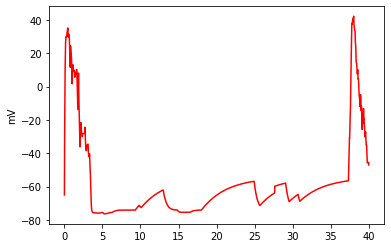

In [ ]:
plt.figure()
plt.plot(model.measurement_time, model.measured_mV, c='r')
plt.ylabel('mV')
plt.show()

In [ ]:
model.measured_gate_states[50]

array([[0.31771858, 0.        ],
       [0.05300853, 0.5961537 ],
       [1.        , 0.        ]])

In [ ]:
model.measured_gate_states[4]

array([[0.31771858, 0.        ],
       [0.05300853, 0.5961537 ],
       [1.        , 0.        ]])

In [ ]:
class Node:
    def __init__(self, data, next=None):
        self.data = data
        self.next = next

class linkedList:
    def __init__(self, head=None):
        self.head = head

    def __str__(self):
        res = ""
        pointer = self.head
        while pointer:
            res += str(pointer.data) + ", "
            pointer = pointer.next 
        if len(res):
            return "[" + res + "]"
        else:
            return "[]"

In [ ]:
E_R = 0

# mV = np.linspace(-80, 60, 1000) + E_R
# mV = -E_R - np.linspace(-80, 60, 1000)
mV = -E_R - np.linspace(-80, 60, 1000)

 
alpha_n2 = 0.001265 * (mV + 14.273) / (1 - np.exp((mV + 14.273) / -10))
alpha_h_s = 0.0658 * np.exp(-(mV + 120) / 20.33)
alpha_m_s = 11.49 / (1 + np.exp((mV + 8.58) / -8.47))
alpha_h_rp = 0.06435 / (1 + np.exp((mV + 73.26415) / 3.71928))
alpha_m_rp = 1.032 / (1 + np.exp((mV + 6.99) / -14.87115))

beta_n2 = 0.125 * np.exp((mV + 55) / -2.5)
beta_h_s = 3.0 / (1 + np.exp((mV - 6.8) / -12.998))
beta_m_s = 11.49 / (1 + np.exp((mV + 67.2) / 27.8))
beta_h_rp = 5.79/ (1 + np.exp((mV + 130.4) / 22.9))
beta_m_rp = 0.13496 / (1 + np.exp((mV + 10.27853) / -9.09334))

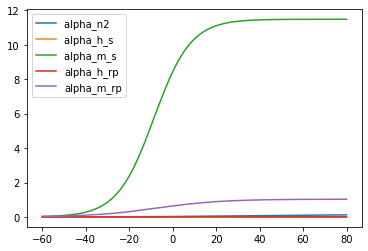

In [ ]:
mV += E_R


plt.figure()
plt.plot()
plt.plot(mV, alpha_n2  , label='alpha_n2  ')
plt.plot(mV, alpha_h_s , label='alpha_h_s ')
plt.plot(mV, alpha_m_s , label='alpha_m_s ')
plt.plot(mV, alpha_h_rp, label='alpha_h_rp')
plt.plot(mV, alpha_m_rp, label='alpha_m_rp')
plt.legend()
plt.show()

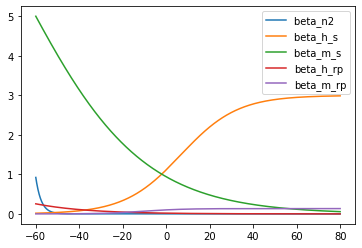

In [ ]:
plt.figure()
plt.plot()
plt.plot(mV, beta_n2  , label='beta_n2  ')
plt.plot(mV, beta_h_s , label='beta_h_s ')
plt.plot(mV, beta_m_s , label='beta_m_s ')
plt.plot(mV, beta_h_rp, label='beta_h_rp')
plt.plot(mV, beta_m_rp, label='beta_m_rp')
plt.legend()
plt.show()

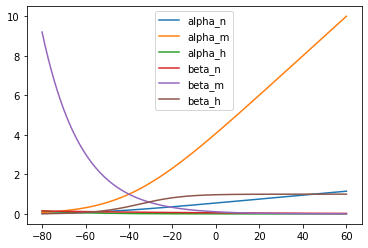

In [ ]:
mV = np.linspace(-80, 60, 1000)


alpha_n = (0.01 * (mV + 55)) / (1 - np.exp(-(mV + 55) / 10))
alpha_m = (0.1 * (mV + 40)) / (1 - np.exp(-(mV + 40) / 10))
alpha_h = 0.07 * np.exp(-(mV + 65) / 20)
beta_n = 0.125 * np.exp(-(mV + 65 ) / 80)
beta_m = 4 * np.exp(-(mV + 65) / 18)
beta_h = 1 / (1 + np.exp(-(mV + 35) / 10))

plt.figure()
plt.plot()
plt.plot(mV, alpha_n, label='alpha_n')
plt.plot(mV, alpha_m, label='alpha_m')
plt.plot(mV, alpha_h, label='alpha_h')
plt.plot(mV, beta_n,  label='beta_n')
plt.plot(mV, beta_m,  label='beta_m')
plt.plot(mV, beta_h,  label='beta_h')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b41179c-5576-4bbe-b1da-6aa3feec5d82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>